In [1]:
from ultralytics import YOLO
import os
import numpy as np
import math
import pandas as pd
from scipy.signal import find_peaks
import networkx as nx
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import torch
import cv2
import json
import geopandas as gpd
from shapely.geometry import Point, Polygon
from scipy.spatial import KDTree

In [3]:
# Загрузка модели YOLO
model = YOLO('best.pt')  

# Папка с изображениями
images_folder = 'camera52HD/'  
allowed_ext = ('.jpg', '.jpeg', '.png')

# Цвета для классов (если у вас есть несколько классов, подставьте нужные цвета)
class_colors = {
    0: (0, 255, 0),    # Класс 0 — зелёный
    1: (255, 0, 0),    # Класс 1 — синий
    2: (0, 0, 255),    # Класс 2 — красный
}

# Список изображений
image_files = sorted(
    [f for f in os.listdir(images_folder) if f.lower().endswith(tuple(allowed_ext))]
)

# Список для хранения данных распознавания
data = []

# Обрабатываем изображения
for filename in image_files:
    image_path = os.path.join(images_folder, filename)
    img = cv2.imread(image_path)

    if img is None:
        print(f"Ошибка загрузки изображения: {filename}")
        continue

    print(f"\n📷 Обрабатываем: {filename}")

    # Получаем результаты распознавания
    result = model(img)[0]

    # Обработка каждого найденного объекта
    for box in result.boxes:
        cls_id = int(box.cls.item())  # ID класса
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Координаты рамки
        label = model.names[cls_id]  # Название класса
        conf = float(box.conf.item())  # Уверенность
        text = f"{label}: {conf:.2f}"

        # Вычисление центра рамки
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        center = (center_x, center_y)

        # Добавляем данные в список
        data.append({
            'filename': filename,
            'class_id': cls_id,
            'x1': x1,
            'y1': y1,
            'x2': x2,
            'y2': y2,
            'center': center
        })

        # Цвет рамки
        color = class_colors.get(cls_id, (255, 255, 255))

        # Рисуем рамку и подписываем класс на изображении
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Отображаем изображение в отдельном окне
    cv2.imshow(f"Обнаруженные объекты на {filename}", img)

    # Ожидаем, пока пользователь не закроет окно
    cv2.waitKey(0)  # Ожидаем нажатие клавиши

# Закрытие всех окон после завершения обработки
cv2.destroyAllWindows()

# Создаем DataFrame
df = pd.DataFrame(data)



📷 Обрабатываем: camera52HD_5-12-2023-1500-00000_jpg.rf.578c81672d62ea4da1433980bf659bbd.jpg

0: 384x640 16 persons, 8 trolleys, 118.7ms
Speed: 2.2ms preprocess, 118.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

📷 Обрабатываем: camera52HD_5-12-2023-1500-00001_jpg.rf.390282565a00f435c70e3e1892faa0f2.jpg

0: 384x640 15 persons, 9 trolleys, 109.8ms
Speed: 1.5ms preprocess, 109.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

📷 Обрабатываем: camera52HD_5-12-2023-1500-00002_jpg.rf.d8196a30ae7add0066c6386fca4490db.jpg

0: 384x640 14 persons, 10 trolleys, 134.4ms
Speed: 1.7ms preprocess, 134.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

📷 Обрабатываем: camera52HD_5-12-2023-1500-00003_jpg.rf.b570032505bc104d72e530695849f5fb.jpg

0: 384x640 16 persons, 10 trolleys, 135.2ms
Speed: 2.0ms preprocess, 135.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

📷 Обрабатываем: camera52HD_5-12-2023-1500-00004_jpg.rf.b0

In [4]:
def rect_to_polygon(row):
    x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
    # Углы прямоугольника по часовой стрелке
    return Polygon([
        (x1, y1),
        (x2, y1),
        (x2, y2),
        (x1, y2)
    ])

# Применяем к каждой строке
df['geometry'] = df.apply(rect_to_polygon, axis=1)

# Преобразуем в GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf['square'] = gdf.geometry.area
print(gdf)

                                              filename  class_id    x1   y1  \
0    camera52HD_5-12-2023-1500-00000_jpg.rf.578c816...         2  1027  424   
1    camera52HD_5-12-2023-1500-00000_jpg.rf.578c816...         2   675  529   
2    camera52HD_5-12-2023-1500-00000_jpg.rf.578c816...         1   765  264   
3    camera52HD_5-12-2023-1500-00000_jpg.rf.578c816...         1   580  618   
4    camera52HD_5-12-2023-1500-00000_jpg.rf.578c816...         2     2  539   
..                                                 ...       ...   ...  ...   
298  camera52HD_5-12-2023-1500-00015_jpg.rf.b3a6011...         1   705  111   
299  camera52HD_5-12-2023-1500-00015_jpg.rf.b3a6011...         1   871   54   
300  camera52HD_5-12-2023-1500-00015_jpg.rf.b3a6011...         2   723  128   
301  camera52HD_5-12-2023-1500-00015_jpg.rf.b3a6011...         1   709  138   
302  camera52HD_5-12-2023-1500-00015_jpg.rf.b3a6011...         2   942  160   

       x2   y2           center  \
0    1135  602  

In [4]:



def find_max_intersection_class_1(row, class_1_geometries):
    max_intersection = 0
    best_match = None

    for geom in class_1_geometries:
        # Вычисляем пересечение (intersection) между объектом класса 0/2 и классом 1
        intersection = row['geometry'].intersection(geom)
        
        # Если есть пересечение и оно больше, чем предыдущие
        if not intersection.is_empty:
            intersection_area = intersection.area
            if intersection_area > max_intersection:
                max_intersection = intersection_area
                best_match = geom

    return best_match, max_intersection

# Пример группировки по filename
grouped = gdf.groupby('filename')

# Массив для сохранения результатов
group_labels = []

for filename, group in grouped:
    # Сначала выделим объекты класса 1
    class_1_geometries = group[group['class_id'] == 1]['geometry'].tolist()

    # Создадим новый столбец для группировки и рамки
    group['group_id'] = None
    group['bbox'] = None  # Добавляем новый столбец для хранения рамки (bounding box)

    for index, row in group.iterrows():
        # Если класс 0 или 2, ищем пересечение с классом 1
        if row['class_id'] in [0, 2]:
            best_match, max_intersection = find_max_intersection_class_1(row, class_1_geometries)

            if best_match is not None:
                # Если пересечение найдено, группируем
                group.at[index, 'group_id'] = best_match  # Присваиваем объект с максимальным пересечением

                # Вычисляем bounding box для группы (объектов класса 1 и текущего класса 0/2)
                combined_geom = row['geometry'].union(best_match)  # Объединяем геометрии
                bbox = combined_geom.bounds  # Получаем bounding box: (minx, miny, maxx, maxy)

                # Убедимся, что bbox - это одиночный кортеж и присваиваем его
                group.at[index, 'bbox'] = bbox  # Добавляем bounding box в столбец 'bbox'
            else:
                # Если пересечений нет, объект остаётся в отдельной группе
                group.at[index, 'group_id'] = f"no_match_{index}"

    # Добавляем результат группы обратно
    group_labels.append(group)

# Собираем все группы обратно в один GeoDataFrame
result_gdf = gpd.GeoDataFrame(pd.concat(group_labels, ignore_index=True), geometry='geometry')

# Просматриваем результаты
print(result_gdf[['filename', 'class_id', 'group_id', 'bbox']])

                                              filename  class_id  \
0    camera52HD_5-12-2023-1500-00000_jpg.rf.578c816...         2   
1    camera52HD_5-12-2023-1500-00000_jpg.rf.578c816...         2   
2    camera52HD_5-12-2023-1500-00000_jpg.rf.578c816...         1   
3    camera52HD_5-12-2023-1500-00000_jpg.rf.578c816...         1   
4    camera52HD_5-12-2023-1500-00000_jpg.rf.578c816...         2   
..                                                 ...       ...   
298  camera52HD_5-12-2023-1500-00015_jpg.rf.b3a6011...         1   
299  camera52HD_5-12-2023-1500-00015_jpg.rf.b3a6011...         1   
300  camera52HD_5-12-2023-1500-00015_jpg.rf.b3a6011...         2   
301  camera52HD_5-12-2023-1500-00015_jpg.rf.b3a6011...         1   
302  camera52HD_5-12-2023-1500-00015_jpg.rf.b3a6011...         2   

                                              group_id  \
0    POLYGON ((1097 404, 1188 404, 1188 587, 1097 5...   
1    POLYGON ((674 393, 758 393, 758 668, 674 668, ...   
2        

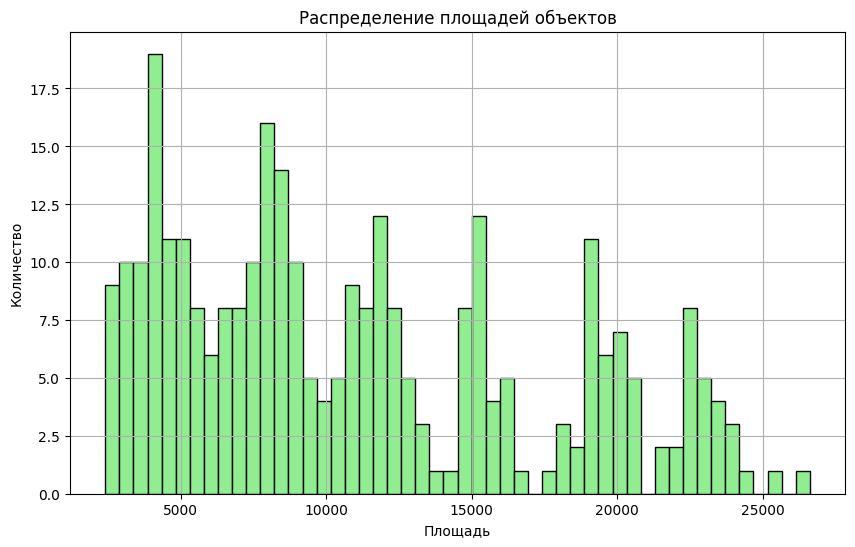

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(gdf.square, bins=50, color='lightgreen', edgecolor='black')
plt.title("Распределение площадей объектов")
plt.xlabel("Площадь")
plt.ylabel("Количество")
plt.grid(True)
plt.show()

In [20]:
# Предположим, что intersection_areas — это список всех пересечений
hist_vals, bin_edges = np.histogram(gdf.square, bins=50)

# Находим пики на гистограмме
peaks, _ = find_peaks(hist_vals, prominence=2)

# Середины корзин (bin centers)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Ширина окна вокруг пика (в единицах площади пересечения)
delta = 1800

# Сохраняем результаты
for peak_idx in peaks:
    peak_center = bin_centers[peak_idx]
    
    # Выбираем значения в пределах ±delta от пика
    area_window = [area for area in gdf.square if abs(area - peak_center) <= delta]
    
    if area_window:
        mean = np.mean(area_window)
        std = np.std(area_window)
        print(f"📌 Пик на ~{peak_center:.0f} → Среднее: {mean:.1f}, Ст. отклонение: {std:.1f}, Кол-во: {len(area_window)}")

📌 Пик на ~4095 → Среднее: 4127.2, Ст. отклонение: 926.9, Кол-во: 80
📌 Пик на ~7971 → Среднее: 7926.2, Ст. отклонение: 892.2, Кол-во: 74
📌 Пик на ~11846 → Среднее: 11704.7, Ст. отклонение: 808.8, Кол-во: 51
📌 Пик на ~15237 → Среднее: 15256.5, Ст. отклонение: 619.6, Кол-во: 32
📌 Пик на ~19112 → Среднее: 19465.9, Ст. отклонение: 792.8, Кол-во: 35
📌 Пик на ~22503 → Среднее: 22783.6, Ст. отклонение: 836.5, Кол-во: 26


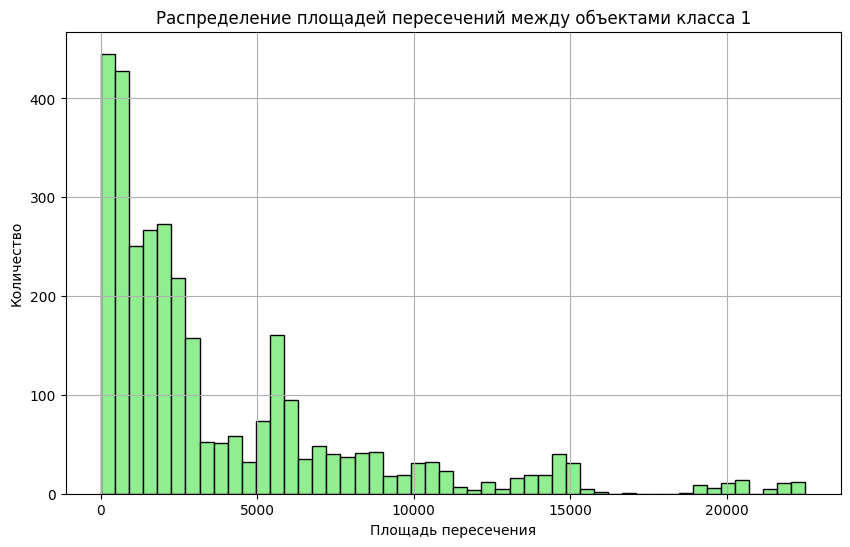

In [10]:

# Отбираем только объекты класса 1
class_1 = gdf[gdf['class_id'] == 1]

# Список для хранения площадей пересечений
intersection_areas = []

# Перебираем все уникальные пары объектов класса 1
for i, row1 in class_1.iterrows():
    for j, row2 in class_1.iterrows():
        if i >= j:
            continue  # чтобы не считать сам с собой и не дублировать

        inter = row1['geometry'].intersection(row2['geometry'])
        if not inter.is_empty:
            intersection_areas.append(inter.area)

# Строим гистограмму распределения
plt.figure(figsize=(10, 6))
plt.hist(intersection_areas, bins=50, color='lightgreen', edgecolor='black')
plt.title("Распределение площадей пересечений между объектами класса 1")
plt.xlabel("Площадь пересечения")
plt.ylabel("Количество")
plt.grid(True)
plt.show()

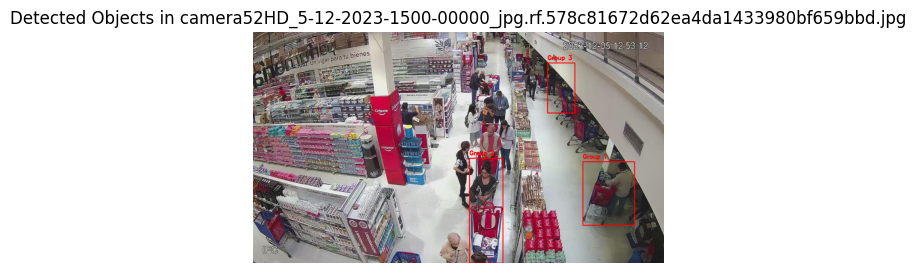

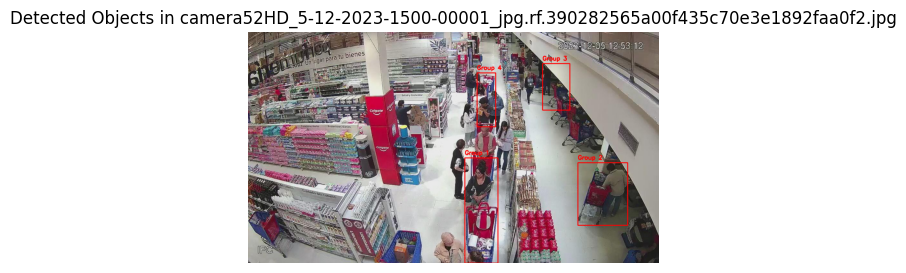

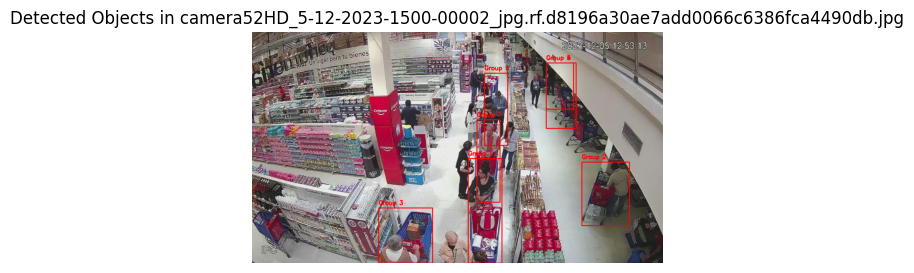

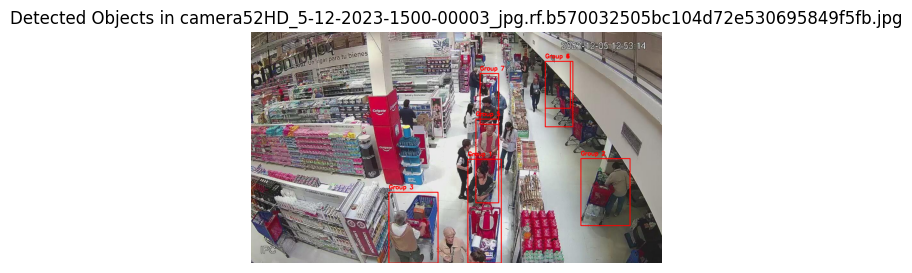

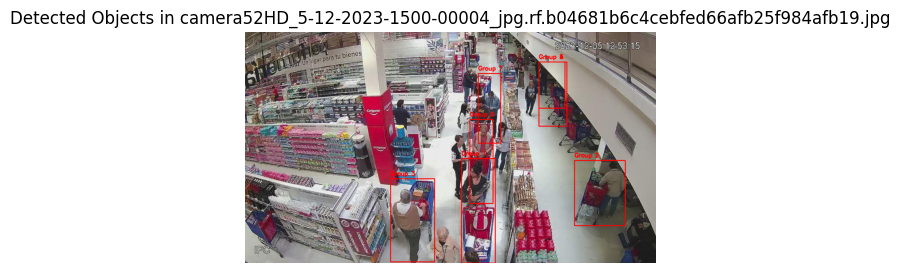

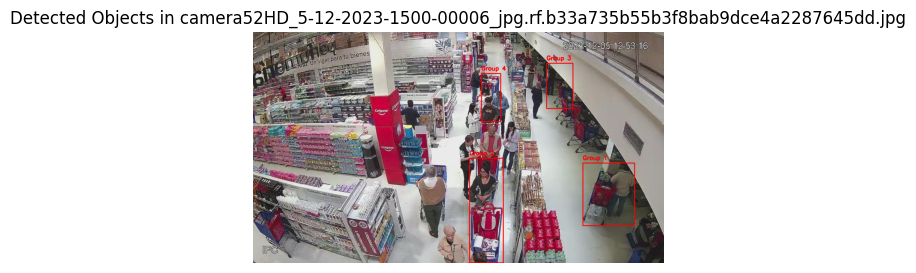

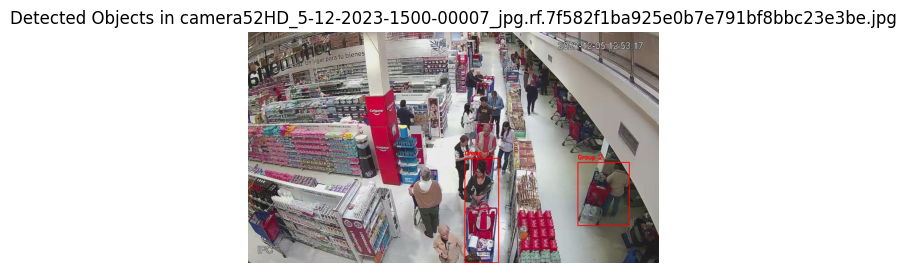

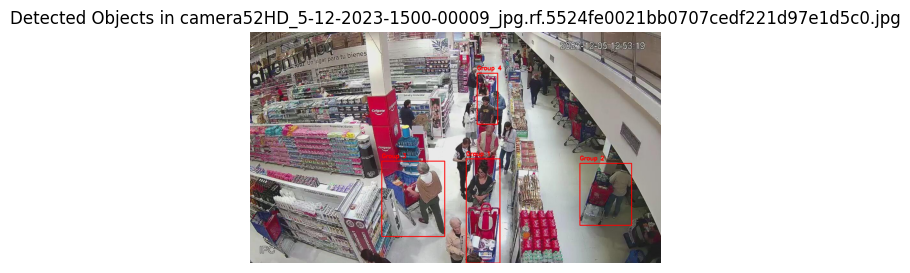

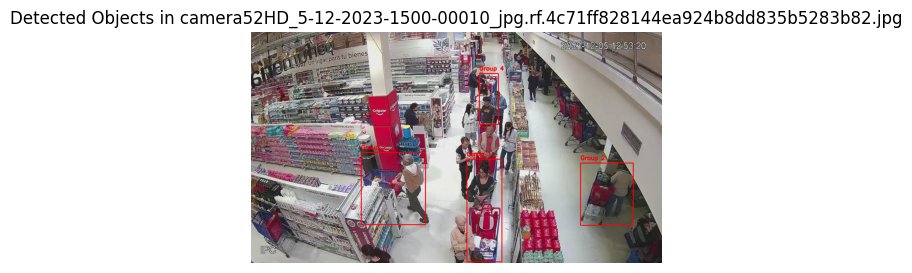

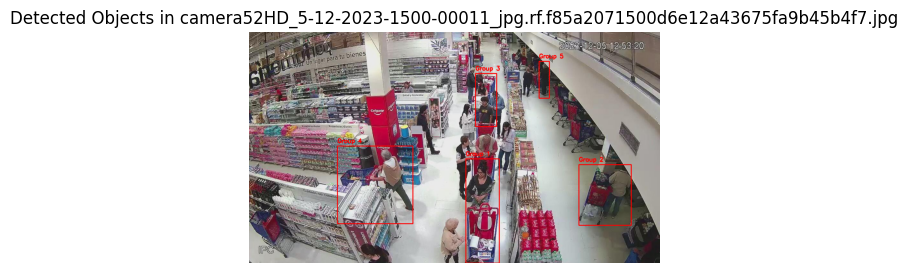

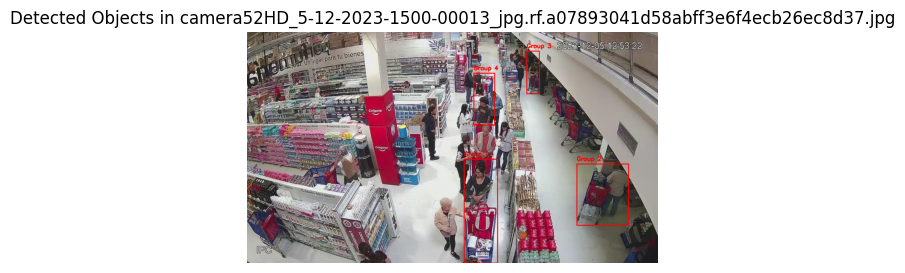

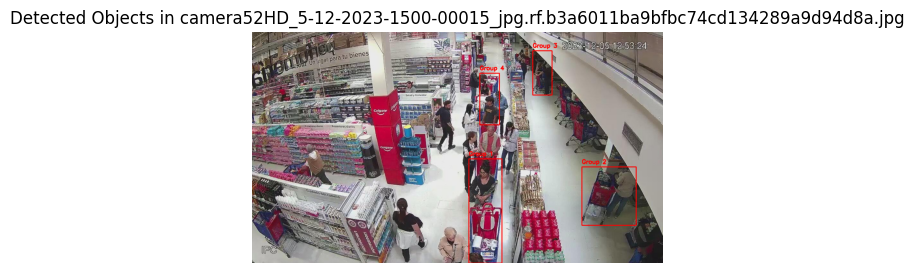

In [8]:
# Группируем по filename и собираем все bounding box'ы групп
grouped = result_gdf.groupby('filename')['bbox'].apply(
    lambda bboxes: [bbox for group in bboxes if group is not None for bbox in (group if isinstance(group[0], list) else [group])]
).reset_index()
figsize = (12, 3)
# Проходим по каждой строке и рисуем рамки на изображениях
for _, row in grouped.iterrows():
    filename = row['filename']
    image_path = os.path.join(images_folder, filename)
    image = cv2.imread(image_path)

    if image is None:
        print(f"⚠️ Не удалось загрузить изображение: {filename}")
        continue

    # Получаем список всех рамок (bounding boxes) для текущего файла
    all_bboxes = row['bbox']  # Список с bounding boxes
    for i, bbox in enumerate(all_bboxes):
        # Распаковываем координаты bounding box (minx, miny, maxx, maxy)
        x1, y1, x2, y2 = map(int, bbox)
        
        # Цвет рамки (например, красный)
        color = (0, 0, 255)
        
        # Рисуем рамку для группы
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        
        # Добавляем текст с номером группы
        cv2.putText(image, f'Group {i+1}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


    # Преобразуем изображение в RGB для отображения в matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Отображаем изображение с рамками
    plt.figure(figsize=figsize)
    plt.imshow(image_rgb)
    plt.title(f"Detected Objects in {filename}")
    plt.axis("off")
    plt.show()